Shape of HSI data: (145, 145, 200)
Shape of ground truth: (145, 145)
hi


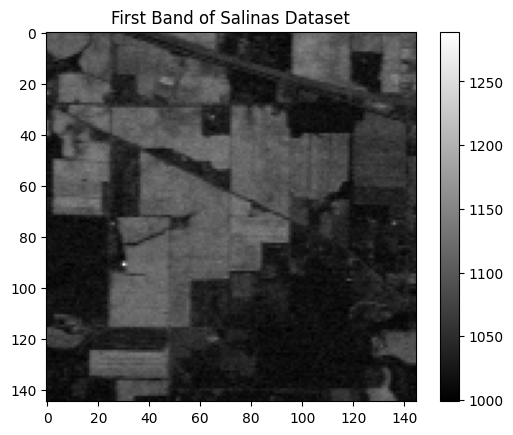

In [38]:
import scipy.io as sio
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the hyperspectral data and ground-truth labels
data = sio.loadmat('Indian_pines_corrected.mat')  # Replace with your file path
ground_truth_data = sio.loadmat('Indian_pines_gt.mat')  # Replace with your file path

# Extract hyperspectral image and ground truth
hsi_data = data['indian_pines_corrected']  # HSI data, shape (145, 145, 200)
ground_truth = ground_truth_data['indian_pines_gt']  # Ground truth labels, shape (145, 145)

print("Shape of HSI data:", hsi_data.shape)
print("Shape of ground truth:", ground_truth.shape)

# Normalize the hyperspectral data to the range [0, 1]
hsi_data_normalized = hsi_data.astype(np.float32)
hsi_data_normalized = (hsi_data_normalized - np.min(hsi_data_normalized)) / (np.max(hsi_data_normalized) - np.min(hsi_data_normalized))

# Flatten the HSI data and ground truth for pixel-based processing
num_pixels = hsi_data_normalized.shape[0] * hsi_data_normalized.shape[1]
num_bands = hsi_data_normalized.shape[2]
data_reshaped = hsi_data_normalized.reshape(num_pixels, 1, num_bands)
labels = ground_truth.flatten()

# Filter out background pixels (typically labeled as 0)
valid_indices = labels > 0
data_reshaped = data_reshaped[valid_indices]
labels = labels[valid_indices] - 1  # Shift labels to start from 0

# Convert data and labels to PyTorch tensors
data_tensor = torch.tensor(data_reshaped, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create dataset and dataloader
batch_size = 64
dataset = TensorDataset(data_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("hi")
# Display the first band as an example
import matplotlib.pyplot as plt

plt.imshow(hsi_data[:, :, 192], cmap='gray')
plt.title('First Band of Salinas Dataset')
plt.colorbar()
plt.show()

In [39]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv1d(in_channels, 1, kernel_size=1)
        
    def forward(self, x):
        attention_weights = self.conv(x)
        attention_weights = F.relu(attention_weights)
        attention_weights = F.softmax(attention_weights, dim=2)
        return attention_weights * x

# Define the CNN with Attention-based Band Selection
class AttentionBasedCNN(nn.Module):
    def __init__(self, num_bands, num_classes):
        super(AttentionBasedCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 96, kernel_size=5, padding=2)
        self.att1 = AttentionModule(96)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(96, 54, kernel_size=5, padding=2)
        self.att2 = AttentionModule(54)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(54, 36, kernel_size=5, padding=2)
        self.att3 = AttentionModule(36)
        self.pool3 = nn.MaxPool1d(2)
        
        self.fc1 = nn.Linear((num_bands // 8) * 36, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.att1(self.conv1(x))))
        x = self.pool2(F.relu(self.att2(self.conv2(x))))
        x = self.pool3(F.relu(self.att3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [40]:
# Training parameters
num_classes = len(np.unique(labels))  # Calculate the number of classes from labels
learning_rate = 0.001
num_epochs = 30

# Initialize model, optimizer, and loss function
model = AttentionBasedCNN(num_bands=num_bands, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/30], Loss: 2.4944
Epoch [2/30], Loss: 2.3311
Epoch [3/30], Loss: 2.3284
Epoch [4/30], Loss: 2.3277
Epoch [5/30], Loss: 2.3276
Epoch [6/30], Loss: 2.3276
Epoch [7/30], Loss: 2.3272
Epoch [8/30], Loss: 2.3260
Epoch [9/30], Loss: 2.3242
Epoch [10/30], Loss: 2.0589
Epoch [11/30], Loss: 1.4833
Epoch [12/30], Loss: 1.3718
Epoch [13/30], Loss: 1.3152
Epoch [14/30], Loss: 1.2725
Epoch [15/30], Loss: 1.2329
Epoch [16/30], Loss: 1.2035
Epoch [17/30], Loss: 1.1774
Epoch [18/30], Loss: 1.1594
Epoch [19/30], Loss: 1.1428
Epoch [20/30], Loss: 1.1166
Epoch [21/30], Loss: 1.0959
Epoch [22/30], Loss: 1.0856
Epoch [23/30], Loss: 1.0636
Epoch [24/30], Loss: 1.0420
Epoch [25/30], Loss: 1.0279
Epoch [26/30], Loss: 1.0077
Epoch [27/30], Loss: 1.0048
Epoch [28/30], Loss: 0.9952
Epoch [29/30], Loss: 0.9815
Epoch [30/30], Loss: 0.9690


In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
data_train, data_test, labels_train, labels_test = train_test_split(
    data_tensor, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
data_train = torch.tensor(data_train, dtype=torch.float32)
data_test = torch.tensor(data_test, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_test = torch.tensor(labels_test, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(data_train, labels_train)
test_dataset = TensorDataset(data_test, labels_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, digits=4)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)
    
    return accuracy, conf_matrix, class_report

# Example usage with test_loader
test_accuracy, test_conf_matrix, test_class_report = evaluate_model(model, test_loader)


/tmp/ipykernel_196/1812461961.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_train = torch.tensor(data_train, dtype=torch.float32)
/tmp/ipykernel_196/1812461961.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_test = torch.tensor(data_test, dtype=torch.float32)


Accuracy: 0.6195
Confusion Matrix:
 [[  6   0   0   0   2   0   0   8   0   0   0   0   0   0   0   0]
 [  0  81  20  12   0   0   0   0   0  31  95  30   0   0   0   0]
 [  0  24  46   2   0   0   0   0   0   6  93   6   0   0   0   0]
 [  0   8   0  13   1   6   0   0   0   0   8   2   0   0   1   0]
 [  0   1   0   1  29  10   1   0   0   1   1   0   0  52   1   0]
 [  0   0   0   3   0 149   0   0   0   0   0   0   0   3   1   0]
 [  0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0 104   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0]
 [  0   2   4   1   0   2   0   0   0 115  77   7   0   0   0   0]
 [  0   6   6   3   0   6   0   0   0  51 383  11   0   0   3   0]
 [  0  26  17   2   0   0   0   0   0  12  31  34   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  31   0   3   0]
 [  0   0   0   0   4   1   0   0   0   0   0   0   0 228   6   0]
 [  2   0   1   4   5  13 

/home/harsha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/harsha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/harsha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
with torch.no_grad():
    attention_scores = []
    for data, _ in train_loader:
        # Pass through attention layers to get attention scores
        a1 = model.att1(model.conv1(data))
        a2 = model.att2(model.conv2(a1))
        a3 = model.att3(model.conv3(a2))
        
        # Aggregate the attention scores from the last layer
        attention_scores.append(a3.cpu().numpy())
    
    # Average attention scores across all batches
    attention_scores = np.concatenate(attention_scores, axis=0)
    attention_scores = attention_scores.mean(axis=0)
mean_attention_scores = attention_scores.mean(axis=0)
from sklearn.ensemble import IsolationForest

def select_important_bands_isolation_forest(attention_scores, contamination_rate=0.01):
    """
    Selects important bands using IsolationForest for outlier detection.
    """
    model = IsolationForest(contamination=contamination_rate, random_state=42)
    selected_bands = model.fit_predict(attention_scores.reshape(-1, 1))
    important_band_indices = [i for i, v in enumerate(selected_bands) if v == -1]
    return important_band_indices

# Call the function on mean attention scores
important_bands = select_important_bands_isolation_forest(mean_attention_scores)
print("Important Bands Selected:", important_bands)


Important Bands Selected: [41, 42]
